In [2]:
# import dependencies
from bs4 import BeautifulSoup as bs
import pandas as pd
from selenium import webdriver
from zipfile import ZipFile
import urllib.request
import os
import numpy as np
import matplotlib.pyplot as plt

## Get zip file links

In [26]:
# since we can't use requests to get links from the html,
# we must use chromedriver to emulate visiting the page
browser = webdriver.Chrome()
browser.get('https://s3.amazonaws.com/tripdata/index.html')

# get all the anchors in the page
anchors = browser.find_elements_by_tag_name('a')

# create list of all the links
links_all = [link.get_attribute('href') for link in anchors]

# create list of 2019 NYC links
links_2019 = [link for link in links_all if 'JC' in link and '2019' in link]

# preview links
links_2019

['https://s3.amazonaws.com/tripdata/JC-201901-citibike-tripdata.csv.zip',
 'https://s3.amazonaws.com/tripdata/JC-201902-citibike-tripdata.csv.zip',
 'https://s3.amazonaws.com/tripdata/JC-201903-citibike-tripdata.csv.zip',
 'https://s3.amazonaws.com/tripdata/JC-201904-citibike-tripdata.csv.zip',
 'https://s3.amazonaws.com/tripdata/JC-201905-citibike-tripdata.csv.zip',
 'https://s3.amazonaws.com/tripdata/JC-201906-citibike-tripdata.csv.zip',
 'https://s3.amazonaws.com/tripdata/JC-201907-citibike-tripdata.csv.zip',
 'https://s3.amazonaws.com/tripdata/JC-201908-citibike-tripdata.csv.zip',
 'https://s3.amazonaws.com/tripdata/JC-201909-citibike-tripdata.csv.zip',
 'https://s3.amazonaws.com/tripdata/JC-201910-citibike-tripdata.csv.zip',
 'https://s3.amazonaws.com/tripdata/JC-201911-citibike-tripdata.csv.zip',
 'https://s3.amazonaws.com/tripdata/JC-201912-citibike-tripdata.csv.zip']

## Create Dataframe containing 2019 data for Jersey City

In [28]:
# function for creating dataframe for each link
def create_df(link):
    
    # create local zip file
    url = urllib.request.urlopen(link)
    open('temp.zip', 'wb').write(url.read())
        
    # read with zipfile, select the csv, create dataframe from csv
    with ZipFile('temp.zip') as myzip:
        with myzip.open(link.split('/')[4].split('.z')[0]) as myfile:
            df = pd.read_csv(myfile)
        
    # rename columns
    df.columns = ['Trip Duration', 
                  'Start Time', 
                  'Stop Time', 
                  'Start Station ID', 
                  'Start Station Name', 
                  'Start Station Latitude', 
                  'Start Station Longitude', 
                  'End Station ID', 
                  'End Station Name', 
                  'End Station Latitude', 
                  'End Station Longitude', 
                  'Bike ID', 
                  'User Type', 
                  'Birth Year', 
                  'Gender']
    
    # print link for confirmation
    print(link)
    
    # remove temperary file
    os.remove('temp.zip')
    
    return df

In [29]:
# create dataframe containing all the 2019 NYC links
df_2019 = pd.DataFrame()
for link in links_2019:
    df = create_df(link)
    df_2019 = df_2019.append(df, ignore_index=True, sort=False)

https://s3.amazonaws.com/tripdata/JC-201901-citibike-tripdata.csv.zip
https://s3.amazonaws.com/tripdata/JC-201902-citibike-tripdata.csv.zip
https://s3.amazonaws.com/tripdata/JC-201903-citibike-tripdata.csv.zip
https://s3.amazonaws.com/tripdata/JC-201904-citibike-tripdata.csv.zip
https://s3.amazonaws.com/tripdata/JC-201905-citibike-tripdata.csv.zip
https://s3.amazonaws.com/tripdata/JC-201906-citibike-tripdata.csv.zip
https://s3.amazonaws.com/tripdata/JC-201907-citibike-tripdata.csv.zip
https://s3.amazonaws.com/tripdata/JC-201908-citibike-tripdata.csv.zip
https://s3.amazonaws.com/tripdata/JC-201909-citibike-tripdata.csv.zip
https://s3.amazonaws.com/tripdata/JC-201910-citibike-tripdata.csv.zip
https://s3.amazonaws.com/tripdata/JC-201911-citibike-tripdata.csv.zip
https://s3.amazonaws.com/tripdata/JC-201912-citibike-tripdata.csv.zip


In [59]:
df_2019.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404947 entries, 0 to 404946
Data columns (total 15 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Trip Duration            404947 non-null  int64  
 1   Start Time               404947 non-null  object 
 2   Stop Time                404947 non-null  object 
 3   Start Station ID         404947 non-null  int64  
 4   Start Station Name       404947 non-null  object 
 5   Start Station Latitude   404947 non-null  float64
 6   Start Station Longitude  404947 non-null  float64
 7   End Station ID           404947 non-null  int64  
 8   End Station Name         404947 non-null  object 
 9   End Station Latitude     404947 non-null  float64
 10  End Station Longitude    404947 non-null  float64
 11  Bike ID                  404947 non-null  int64  
 12  User Type                404947 non-null  object 
 13  Birth Year               404947 non-null  int64  
 14  Gend

## Cleaning

In [64]:
# make a copy for cleaning
df_2019_copy = df_2019.copy()

# convert start/stop times to datetime
df_2019_copy['Start Time'] = pd.to_datetime(df_2019_copy['Start Time'])
df_2019_copy['Stop Time'] = pd.to_datetime(df_2019_copy['Stop Time'])

# add age column
df_2019_copy['Age'] = pd.to_numeric(2019 - df_2019_copy['Birth Year'])

# remove trips with riders older than 90
df_2019_copy = df_2019_copy[df_2019_copy['Age'] < 100]

# remove gender values greater than 1
df_2019_copy = df_2019_copy[df_2019_copy['Gender'] < 2]

# remove trips with a duration longer than 24 hours
df_2019_copy['Trip Duration'] = df_2019_copy[df_2019_copy['Trip Duration'] < 86400]
df_2019_copy['Trip Duration'] = pd.to_numeric(df_2019_copy['Trip Duration'])

# drop NAs
df_2019_copy = df_2019_copy.dropna(how='any').reset_index(drop=True)

display(df_2019_copy.describe())
display(df_2019_copy.info())
df_2019_copy

,Trip Duration,Start Station ID,Start Station Latitude,Start Station Longitude,End Station ID,End Station Latitude,End Station Longitude,Bike ID,Birth Year,Gender,Age
count,312491.000000,312491.000000,312491.000000,312491.000000,312491.000000,312491.000000,312491.000000,312491.000000,312491.000000,312491.000000,312491.000000
mean,608.677287,3295.775670,40.722701,-74.046361,3294.597121,40.722305,-74.045859,28468.922999,1980.868899,0.916164,38.131101
std,1806.570567,173.644201,0.007142,0.011010,183.973456,0.007009,0.011012,1653.847759,10.136301,0.277142,10.136301
min,61.000000,3183.000000,40.709651,-74.083639,127.000000,40.701403,-74.083639,14792.000000,1940.000000,0.000000,16.000000
25%,228.000000,3194.000000,40.718355,-74.050656,3192.000000,40.717733,-74.050389,26286.000000,1974.000000,1.000000,30.000000
50%,341.000000,3209.000000,40.721525,-74.043845,3207.000000,40.719586,-74.043117,29284.000000,1983.000000,1.000000,36.000000
75%,578.000000,3276.000000,40.727224,-74.038051,3276.000000,40.727224,-74.037683,29537.000000,1989.000000,1.000000,45.000000
max,86114.000000,3792.000000,40.748716,-74.032108,3792.000000,40.814326,-73.932077,41913.000000,2003.000000,1.000000,79.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 312491 entries, 0 to 312490
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   Trip Duration            312491 non-null  float64       
 1   Start Time               312491 non-null  datetime64[ns]
 2   Stop Time                312491 non-null  datetime64[ns]
 3   Start Station ID         312491 non-null  int64         
 4   Start Station Name       312491 non-null  object        
 5   Start Station Latitude   312491 non-null  float64       
 6   Start Station Longitude  312491 non-null  float64       
 7   End Station ID           312491 non-null  int64         
 8   End Station Name         312491 non-null  object        
 9   End Station Latitude     312491 non-null  float64       
 10  End Station Longitude    312491 non-null  float64       
 11  Bike ID                  312491 non-null  int64         
 12  User Type       

None

,Trip Duration,Start Time,Stop Time,Start Station ID,Start Station Name,Start Station Latitude,Start Station Longitude,End Station ID,End Station Name,End Station Latitude,End Station Longitude,Bike ID,User Type,Birth Year,Gender,Age
0,201.0,2019-01-01 03:09:09.711,2019-01-01 03:12:30.879,3183,Exchange Place,40.716247,-74.033459,3214,Essex Light Rail,40.712774,-74.036486,29612,Subscriber,1993,1,26
1,756.0,2019-01-01 10:36:33.340,2019-01-01 10:49:10.260,3183,Exchange Place,40.716247,-74.033459,3192,Liberty Light Rail,40.711242,-74.055701,26164,Subscriber,1985,1,34
2,1575.0,2019-01-01 12:43:38.643,2019-01-01 13:09:54.528,3183,Exchange Place,40.716247,-74.033459,3638,Washington St,40.724294,-74.035483,29672,Customer,1969,0,50
3,1566.0,2019-01-01 12:43:39.601,2019-01-01 13:09:46.510,3183,Exchange Place,40.716247,-74.033459,3638,Washington St,40.724294,-74.035483,29522,Customer,1969,0,50
4,737.0,2019-01-01 12:56:53.204,2019-01-01 13:09:11.040,3183,Exchange Place,40.716247,-74.033459,3205,JC Medical Center,40.716540,-74.049638,29447,Subscriber,1993,1,26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
312486,283.0,2019-12-31 23:12:18.548,2019-12-31 23:17:01.874,3195,Sip Ave,40.730897,-74.063913,3679,Bergen Ave,40.722104,-74.071455,29245,Customer,1990,1,29
312487,267.0,2019-12-31 23:19:03.584,2019-12-31 23:23:30.664,3186,Grove St PATH,40.719586,-74.043117,3205,JC Medical Center,40.716540,-74.049638,26153,Subscriber,1989,1,30
312488,379.0,2019-12-31 23:19:06.583,2019-12-31 23:25:25.797,3209,Brunswick St,40.724176,-74.050656,3185,City Hall,40.717733,-74.043845,26276,Subscriber,1984,1,35
312489,188.0,2019-12-31 23:24:00.263,2019-12-31 23:27:09.040,3639,Harborside,40.719252,-74.034234,3186,Grove St PATH,40.719586,-74.043117,29461,Subscriber,1987,1,32


## Quick scan for correlations

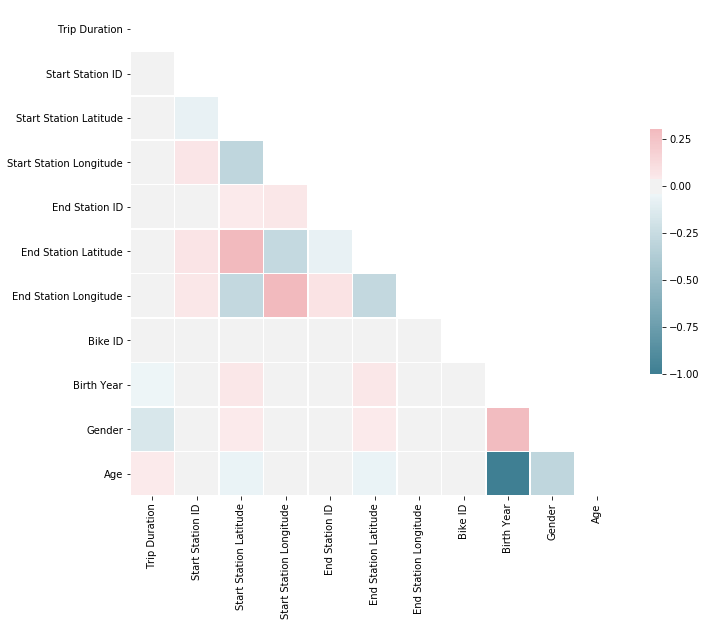

In [63]:
import numpy as np
import matplotlib.pyplot as plt

corr = df_2019_copy.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## Export

In [66]:
df_2019_copy.to_csv('JC_2019.csv', encoding='utf-8', index=False)